# Neural nets with Back-Propagation

Implementating of a neural network with back-propagation as a class in Python.

### It includes: 

*  Understanding the back-propagation algorithm and how to implement it

*  Watching a neural net during learning and see the effect of gradual modification of weights

*  Comparing gradient descent with batch-gradients and stochastic gradients

*  Examining the effect of the learning rate parameter on the learning curve

*  Visualising the changes in weights on successive gradient updates, to see which gradients are changing sign



In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
# the next instruction makes the plots appear within the notebook
%matplotlib inline

First we want some data.

Our data will be points in the plane. We will generate random points within a square, like so:  

In [3]:
X = 2 * np.random.random((200,2)) - 1

# you can re-run with many more than 20 training data points 

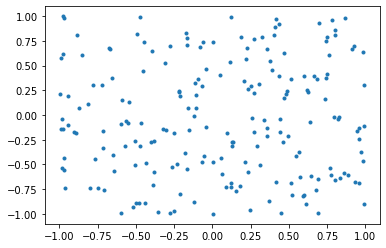

In [4]:
plt.plot(X[:,0],X[:,1],'.')

In [5]:
def classifier1(X):
    # this takes an arry of input points and calculates y values that are 1 on one side of a sloping line
    return(np.sum( X * [0.8,0.2], axis=1) > 0.3).astype(float)

In [6]:
y1 = classifier1(X)

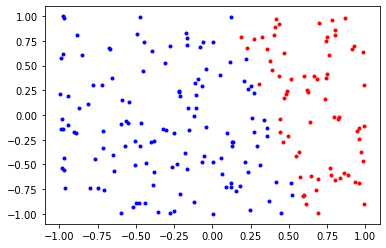

In [7]:
plt.plot(X[y1==0.0,0],X[y1==0.0,1],'b.')
plt.plot(X[y1==1.0,0],X[y1==1.0,1],'r.')

In [8]:
def classifier2(X):
    return (np.sum( X * X, axis=1) < 0.66 ).astype(float)

In [9]:
y2 = classifier2( X ) 

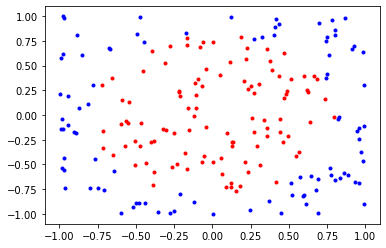

In [10]:
plt.plot(X[y2==0.0,0],X[y2==0.0,1],'b.')
plt.plot(X[y2==1.0,0],X[y2==1.0,1],'r.')

## Defining neuron activation functions

Here is code for a "leaky RELU" activation function, and a logistic activatio function. 

Note that we need to define **two** Python functions for each: the **forward pass** function, which computes the neuron's output from its total input; and the **bacward pass** function which computes the gradient of the outputs for small changes in the inputs.  This gradient is then fed back to earlier layers

In [11]:
def relu_outputs(inputs):
    """ 
    This is the function used in the forward pass,
    which computes the output of each 'neuron' in from the total of inputs
    
    inputs : a ndarray of the total input for each neuron
    
    returns: a ndarray giving the output for each neuron
    """
    return np.maximum(inputs,0) + 0.05 * np.minimum(inputs,0)


In [12]:
def relu_gradients(outputs):
    return (outputs > 0 ).astype(float) + 0.05 * (outputs < 0).astype(float)


Since we are approximating zeros and 1s, it is useful also to define a sigmoid neuron as the output, 
which has a minimum output value of 0 and a maximum output value of 1.

In this neural net we will only have one output neuron, but we define the function to accept a matrix of output neurons anyway. 

In [13]:
def sigmoid_outputs( inputs ):
    return  1.0 / (1.0 + np.exp( -inputs ))

In [14]:
def sigmoid_gradients( outputs ):
    return outputs * (1.0 - outputs)

Next, we define a one hidden layer neural net as a class. 

This class has quite a lot of data: 

In [15]:
class NN2layer:
    
    def __init__(self, n_inputs, n_layer_1): # one hidden layer of neurons, one output neuron
        
        self.n_inputs = n_inputs       # integer: the number of inputs. In this case, always 2
        self.n_layer_1 = n_layer_1     # integer: the number of neurons in the first (hidden) layer
        self.n_layer_2 = 1             # integer: the number of output neurons, in this case always 1 
        
        # weights that will be learned 
        # all these weights will need initialisation before the network is first run
        self.w_1 = np.zeros( [n_inputs, n_layer_1] ) # weights between inputs and first layer neurons
        self.bias_1 = np.zeros( [1, n_layer_1])
        self.w_2 = np.zeros( [n_layer_1, 1] ) # needs initialisation
        self.bias_2 = np.zeros( [1,1])
        
        # quantities calculated during forward pass
        self.X = np.zeros([1,n_inputs]) # the data example that is input ( a 1x2 matrix )
        
        self.inputs_layer_1 = np.zeros([1,n_layer_1])  # row-vector of total inputs to first layer neurons
        self.outputs_layer_1 = np.zeros([1,n_layer_1]) # row-vector of outputs of first layer neurons 
        
        self.inputs_layer_2 = np.zeros([1])   # row vector (in this case of length 1) of total input to second layer neuron
        self.outputs_layer_2 = np.zeros([1])  # row vector (in this case of length 1) of output of second layer neuron
        
        self.predicted_y = 0.0  # the predicted y value (just the output from the second layer neuron in this case)
        
        # quantities calculated during the backward pass
        # each one is initialised to a number or array of the correct size, with zeros
        # this is for readability, to show what the sizes should be
        # the actual values will be replaced during the calculation
        
        self.J = 0.0                 # the loss
        self.dJ_d_predicted_y = 0.0  # gradient of loss with respect to predicted y
        self.dJ_d_outputs_layer_2 = np.array([[0.0]]) 
        self.dJ_d_inputs_layer_2 = 0.0 # this is also dJ_d_bias_2, since bias is added to neuron inputs 
        self.dJ_d_w_2 = np.zeros( [n_layer_1, 1] ) # Same size as weight array  
        self.dJ_d_outputs_layer_1 = np.zeros([1,n_layer_1]) # same size as the vector of outputs (activations) of layer 1   
        self.dJ_d_inputs_layer_1 = np.zeros([1,n_layer_1]) 
        self.dJ_d_w_1 = np.zeros( [n_inputs, n_layer_1] ) 
        
        # in batch or minibatch mode, we average the gradients over many examples.  To do this, we need to 
        # do a forward and backward pass for each example in the batch, and then average the gradients, before
        # finally updating the weights. 
        
        self.n_backward_passes = 0  # number of backward passes in the batch so far 
        self.total_J = 0  # useful for monitoring average loss during training
        self.total_dJ_d_w_2 = np.zeros( [n_layer_1,1] ) # matches size of w_2
        self.total_dJ_d_w_1 = np.zeros( [n_inputs,n_layer_1] )
        self.total_dJ_d_bias_2 = np.zeros( [1,1] )
        self.total_dJ_d_bias_1 = np.zeros( [1, n_layer_1 ] )
        
    def initialise_weights(self, sigma_1, sigma_2):
        """
        Initialises layer 1 weights to zero-mean normal variates with standard deviation sigma_1, 
        and layer 2 weights to normal variates with s.d. sigma_2
        """
        self.w_1 = sigma_1 * np.random.randn( self.w_1.shape[0], self.w_1.shape[1] )
        self.bias_1 = sigma_1 * np.random.randn( 1, self.w_1.shape[1] )
        self.w_2 = sigma_2 * np.random.randn( self.w_2.shape[0], self.w_2.shape[1] )
        
    def forward_pass(self, X): 
        """
        computes the forward pass 
        
        X should be a vector of size [1,n_]
        """
        self.X = X.copy() # we might as well record the input vector; X may be a view or slice, so copy it
        assert self.X.shape == (1, self.n_inputs)
        
        self.inputs_layer_1 = np.dot(self.X, self.w_1 ) + self.bias_1
        self.outputs_layer_1 = relu_outputs( self.inputs_layer_1 )
        self.inputs_layer_2 = np.dot(self.outputs_layer_1, self.w_2 ) + self.bias_2
        self.outputs_layer_2 = sigmoid_outputs( self.inputs_layer_2 )
        self.predicted_y = self.outputs_layer_2[0,0]
    
    def squared_loss( self, y ): # the loss is modular: it needs to compute J, and the gradient of J
        """
        Called after calling forward_pass
        """
        self.J = 0.5 * (self.predicted_y - y)**2
        self.dJ_d_predicted_y = self.predicted_y - y 
        
    def backward_pass(self):
    
        self.dJ_d_outputs_layer_2[0,0] = self.dJ_d_predicted_y # computed by the loss function (e.g. squared_loss)
        self.dJ_d_inputs_layer_2 = sigmoid_gradients(self.outputs_layer_2) * self.dJ_d_outputs_layer_2
        self.dJ_d_w_2 = np.dot( self.outputs_layer_1.transpose(), self.dJ_d_inputs_layer_2 ) 
        self.dJ_d_outputs_layer_1 = np.dot( self.dJ_d_inputs_layer_2, self.w_2.transpose() )
        self.dJ_d_inputs_layer_1 = relu_gradients(self.outputs_layer_1) * self.dJ_d_outputs_layer_1
        self.dJ_d_w_1 = np.dot( self.X.transpose(), self.dJ_d_inputs_layer_1 )
        
        # now update cumulated gradients
        self.n_backward_passes += 1 
        self.total_J += self.J
        self.total_dJ_d_w_2 += self.dJ_d_w_2
        self.total_dJ_d_w_1 += self.dJ_d_w_1
        self.total_dJ_d_bias_2 += self.dJ_d_inputs_layer_2
        self.total_dJ_d_bias_1 += self.dJ_d_inputs_layer_1
        
    def update_weights(self, learning_rate ):
        assert self.n_backward_passes > 0  # otherwise all weights will go to Inf or NaN
        batch_learning_rate = learning_rate / self.n_backward_passes  
        self.w_1 -= batch_learning_rate * self.total_dJ_d_w_1
        self.bias_1 -= batch_learning_rate * self.total_dJ_d_bias_1
        self.w_2 -= batch_learning_rate * self.total_dJ_d_w_2
        self.bias_2 -= batch_learning_rate * self.total_dJ_d_bias_2
        
        # now clean up and set all total gradients and n_backward_passes to 0 
        self.n_backward_passes = 0 
        self.total_J = 0 
        self.total_dJ_d_w_2 *= 0 
        self.total_dJ_d_w_1 *= 0 
        self.total_dJ_d_bias_2 *= 0 
        self.total_dJ_d_bias_1 *= 0       
        
    

In [16]:
def plot_nn_predictions( nn ):
    x_values = np.linspace(-1,1,200)
    y_values = np.linspace(-1,1,200)

    J_grid = np.zeros([x_values.size,y_values.size])

    for x_index in range(0, x_values.size):
        for y_index in range(0, y_values.size):
            nn.forward_pass(np.array([[x_values[x_index], y_values[y_index] ]] ))
            J_grid[x_index,y_index] = nn.predicted_y
    
    plt.imshow(J_grid.transpose(), origin='lower',extent=[-1,1,-1,1])
    plt.colorbar()                                               

In [17]:
nn = NN2layer( 2,16)
nn.initialise_weights(0.2,0.2)

In [18]:
X = 2 * np.random.random((200,2)) - 1

Y = classifier2(X)

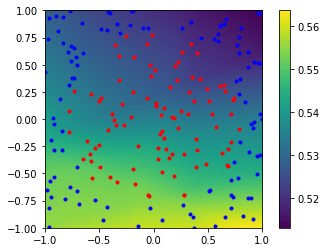

In [19]:
plot_nn_predictions(nn)

plt.plot(X[Y==0.0,0],X[Y==0.0,1],'b.')
plt.plot(X[Y==1.0,0],X[Y==1.0,1],'r.')

Now do some training 

In [20]:
global_mean_J = []

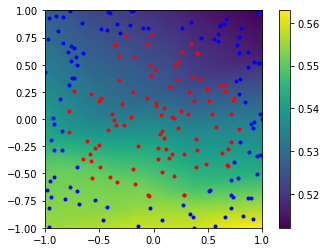

In [21]:
for j in range(0,1):
    for i in range(0,X.shape[0]):
        x_item = X[i:i+1,:]
        y = Y[i]
        nn.forward_pass(x_item)
        nn.squared_loss(y)
        nn.backward_pass()
    
        
    global_mean_J.append( nn.total_J / nn.n_backward_passes )
    nn.update_weights(0.1)
       
    
plot_nn_predictions(nn)

plt.plot(X[Y==0.0,0],X[Y==0.0,1],'b.')
plt.plot(X[Y==1.0,0],X[Y==1.0,1],'r.')

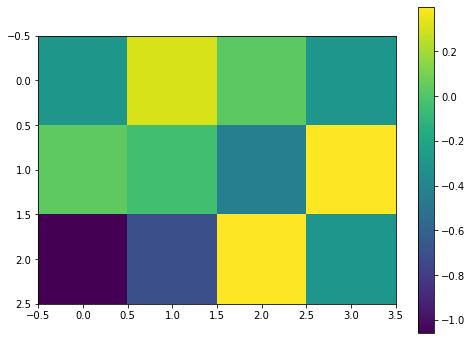

In [38]:
plt.imshow(np.vstack([nn.bias_1,nn.w_1]))
plt.colorbar()

The diagram above is a heatmap of the biases and weights of the first layer neurons. 